In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install plot-keras-history

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.5/322.5 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for plot-keras-history: filename=plot_keras_history-1.1.38-py3-none-any.whl size=9455 sha256=63bbd86c8748fe475053707b1c300be9d38930b5d1f2fd08f459a6042c39c748
  Stored in directory: /root/.cache/pip/wheels/2f/31/6c/bbc9703b7baa8bd3802a8aedd9e2f9e66941b0cf0d456ab4cc
  Created wheel for sanitize_ml_labels: filename=sanitize_ml_labels-1.0.51-py3-none-any.whl size=321865 sha256=6a48e202751d7cabe98a34add7407cb4142f9f5d002067996324922e09f1f479
  Stored in directory: /root/.cache/pip/wheels/30/9f/f5/37d037c39ac8b305590d5956f7021c6ca94b63c68be24f6841
  Created wheel for support_developer: filename=support_developer-1.0.5-py3-none-any.whl size=5630 sha256=df2b257471d860830fc18ccf5522acda32786b06e18dc57cf0b7fca35976c5e9
  Stored in directo

In [ ]:
import os
import numpy as np
import pandas as pd
import shutil
from functools import partial
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import cv2

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, BatchNormalization, Input, Dropout, Conv2D, Permute
from tensorflow.keras import Model
import albumentations as A
from plot_keras_history import show_history, plot_history
from transformers import TFViTModel
AUTOTUNE = tf.data.experimental.AUTOTUNE
%matplotlib inline


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')

In [ ]:
CLASSES = ['fear', 'happy', 'neutral', 'sad', 'surprised'] # delete contempt, disgust and anger
NUM_CLASSES = len(CLASSES)
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 8 * 2
LEARNING_RATE = 1e-3
EPOCHS = 60

In [ ]:
import zipfile
import os
from tqdm import tqdm

# Set the paths
zip_file_path = '/content/drive/MyDrive/archive.zip'  # Update with your actual path
extracted_folder_path = '/content/dataset'  # Update with your desired path

# Create the folder for extracted data
os.makedirs(extracted_folder_path, exist_ok=True)

# Unzip the file with progress bar
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Get the total number of files to extract
    total_files = len(zip_ref.infolist())

    # Use tqdm for progress bar
    for file_info in tqdm(zip_ref.infolist(), desc="Extracting", unit="file", total=total_files):
        zip_ref.extract(file_info, extracted_folder_path)

Extracting: 100%|██████████| 153/153 [00:07<00:00, 20.45file/s]


## 1. Data preparation

In [ ]:
path_dir = '/content/dataset/'
path_csv = os.path.join(path_dir, 'emotions.csv')

In [ ]:
data = pd.read_csv(path_csv)
data

,set_id,gender,age,country
0,0,FEMALE,36,RU
1,1,FEMALE,37,RU
2,2,FEMALE,36,RU
3,3,MALE,29,RU
4,4,FEMALE,43,RU
5,5,MALE,49,RU
6,6,FEMALE,38,RU
7,7,MALE,19,PH
8,8,FEMALE,29,RU
9,9,FEMALE,32,RU


In [ ]:
val_ind = [0, 2, 15, 16, 5] # four females and one male for validation
bad_ind = [11]
data_train = data[~data.index.isin(val_ind + bad_ind)].reset_index(drop=True)
data_val = data[data.index.isin(val_ind)].reset_index(drop=True)

In [ ]:
def create_dirs(data, path, new_path):
    if not os.path.exists(new_path):
        os.makedirs(new_path)
    for class_name in CLASSES:
        os.makedirs(os.path.join(new_path, class_name), exist_ok=True)
    for set_id in data['set_id']:
        for class_name in CLASSES:
            path_src = os.path.join(path, str(set_id), class_name.capitalize() + '.jpg')
            path_dist = os.path.join(new_path, class_name, f'{set_id}_{class_name}.jpg')
            shutil.copyfile(path_src, path_dist)

In [ ]:
#shutil.rmtree(path_val)

In [ ]:
path_train, path_val = 'input/train', 'input/val'
path_imgs = os.path.join(path_dir, 'images')
create_dirs(data_val, path_imgs, path_val)
create_dirs(data_train, path_imgs, path_train)

In [ ]:
dataset_train = tf.keras.utils.image_dataset_from_directory(
    directory=path_train,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASSES,
    color_mode='rgb',
    batch_size=None,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=1,
    validation_split=None,
)

dataset_val = tf.keras.utils.image_dataset_from_directory(
    directory=path_val,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASSES,
    color_mode='rgb',
    batch_size=None,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=1,
    validation_split=None,
)

Found 65 files belonging to 5 classes.
Found 25 files belonging to 5 classes.


In [ ]:
@tf.function
def image_scale(image, label):
    image /= 255.
    return image, label

In [ ]:
dataset_train = dataset_train.map(image_scale,
                                  num_parallel_calls=AUTOTUNE)
dataset_val = dataset_val.map(image_scale,
                                  num_parallel_calls=AUTOTUNE)

In [ ]:
transforms = A.Compose([
    A.CropAndPad(percent=0.17, p=0.2),
    A.HorizontalFlip(p=0.4),
    A.OneOf([
        A.MotionBlur(p=.2),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.Blur(blur_limit=3, p=0.1),
    ], p=0.3),
    A.CoarseDropout(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.27, rotate_limit=10, p=0.3),
    A.OneOf([
            A.Sharpen(),
            A.Emboss(),
            A.RandomBrightnessContrast(),
        ], p=0.3),
])

In [ ]:
def aug_fn(image):
    data = {'image': image}
    image = transforms(**data)['image']
    return image

input_prepoccess_f = lambda image, label: (2. * image - 1., label)

@tf.function
def image_preprocessing(image, label, scale=True):
    image = tf.numpy_function(func=aug_fn, inp=[image],
                              Tout=tf.float32)
    image.set_shape((*IMAGE_SIZE, 3))
    image = tf.clip_by_value(image, clip_value_min=0.,
                               clip_value_max=1.)
    # mobilenet_v2 preprocess of input
    if scale:
        image = 2. * image - 1.
    return image, label

In [ ]:
dataset_train_ = dataset_train.map(partial(image_preprocessing, scale=False), num_parallel_calls=AUTOTUNE
                                  ).shuffle(buffer_size = 8,
                                      reshuffle_each_iteration = True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
buffer_size = len(data)
dataset_train_m = dataset_train.map(image_preprocessing, num_parallel_calls=AUTOTUNE
                                  ).shuffle(buffer_size = buffer_size,
                                      reshuffle_each_iteration = True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
dataset_val_m = dataset_val.map(input_prepoccess_f, num_parallel_calls=AUTOTUNE
                                  ).shuffle(buffer_size = buffer_size,
                                      reshuffle_each_iteration = True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## 2. Model training

In [ ]:
!pip install keras-utils

  Preparing metadata (setup.py) ... done
  Created wheel for keras-utils: filename=keras_utils-1.0.13-py3-none-any.whl size=2631 sha256=1f5e19af203840245d58b3243021f43a385eb935f579420e30160c1b0afc2332
  Stored in directory: /root/.cache/pip/wheels/5c/c0/b3/0c332de4fd71f3733ea6d61697464b7ae4b2b5ff0300e6ca7a
Successfully built keras-utils


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import MaxPooling2D
from plot_keras_history import plot_history

# CNN Model

In [ ]:
model = Sequential()
model.add(Input(shape=IMAGE_SIZE + (3,)))
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=IMAGE_SIZE + (3,)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(GlobalAveragePooling2D())
model.add(Dense(NUM_CLASSES, activation='softmax'))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 conv2d_5 (Conv2D)           (None, 220, 220, 64)      18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 110, 110, 64)      0         
 g2D)                                                            
                                                                 
 batch_normalization_2 (Bat  (None, 110, 110, 64)      256       
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 110, 110, 64)      0         
                                                                 
 conv2d_6 (Conv2D)           (None, 108, 108, 128)    

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss = keras.losses.CategoricalCrossentropy(from_logits=False)
metrics = [keras.metrics.CategoricalAccuracy(), keras.metrics.TopKCategoricalAccuracy(k=2)]
model.compile(optimizer=optimizer,
             loss=loss,
             metrics=metrics)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.8,
                              patience=3, min_lr=5e-5)
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    start_from_epoch=10,
    restore_best_weights=True,
)

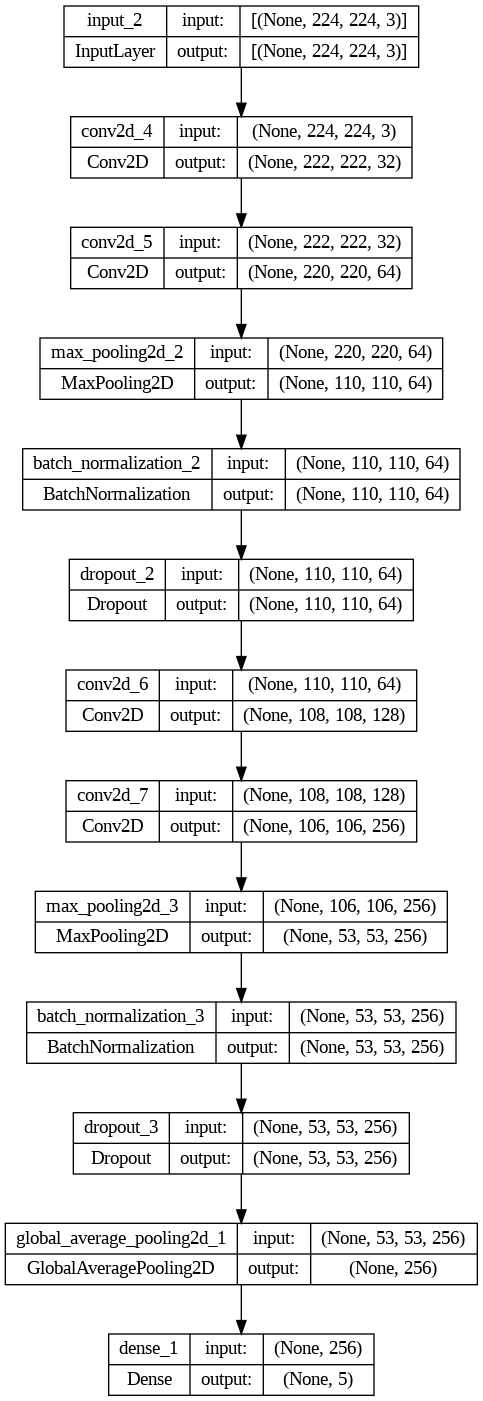

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96)

In [ ]:
# Train the model
history = model.fit(dataset_train_m, epochs=100, validation_data=dataset_val_m, verbose=1, callbacks=[reduce_lr, early_stop])

Epoch 1/100
5/5 [==============================] - 10s 1s/step - loss: 2.3715 - categorical_accuracy: 0.0769 - top_k_categorical_accuracy: 0.2462 - val_loss: 1.6105 - val_categorical_accuracy: 0.1600 - val_top_k_categorical_accuracy: 0.4000 - lr: 0.0010
Epoch 2/100
5/5 [==============================] - 6s 470ms/step - loss: 1.8794 - categorical_accuracy: 0.2462 - top_k_categorical_accuracy: 0.4000 - val_loss: 1.6173 - val_categorical_accuracy: 0.2000 - val_top_k_categorical_accuracy: 0.4400 - lr: 0.0010
Epoch 3/100
5/5 [==============================] - 5s 465ms/step - loss: 1.7474 - categorical_accuracy: 0.2462 - top_k_categorical_accuracy: 0.4308 - val_loss: 1.6167 - val_categorical_accuracy: 0.2400 - val_top_k_categorical_accuracy: 0.3600 - lr: 0.0010
Epoch 4/100
5/5 [==============================] - 7s 595ms/step - loss: 1.6651 - categorical_accuracy: 0.2308 - top_k_categorical_accuracy: 0.4462 - val_loss: 1.6200 - val_categorical_accuracy: 0.2000 - val_top_k_categorical_accuracy

(<Figure size 2000x500 with 4 Axes>,
 array([<Axes: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <Axes: title={'center': 'Categorical accuracy'}, xlabel='Epochs', ylabel='Categorical accuracy'>,
        <Axes: title={'center': 'Top k Categorical accuracy'}, xlabel='Epochs', ylabel='Top k Categorical accuracy'>,
        <Axes: title={'center': 'Learning rate'}, xlabel='Epochs', ylabel='Learning rate'>],
       dtype=object))

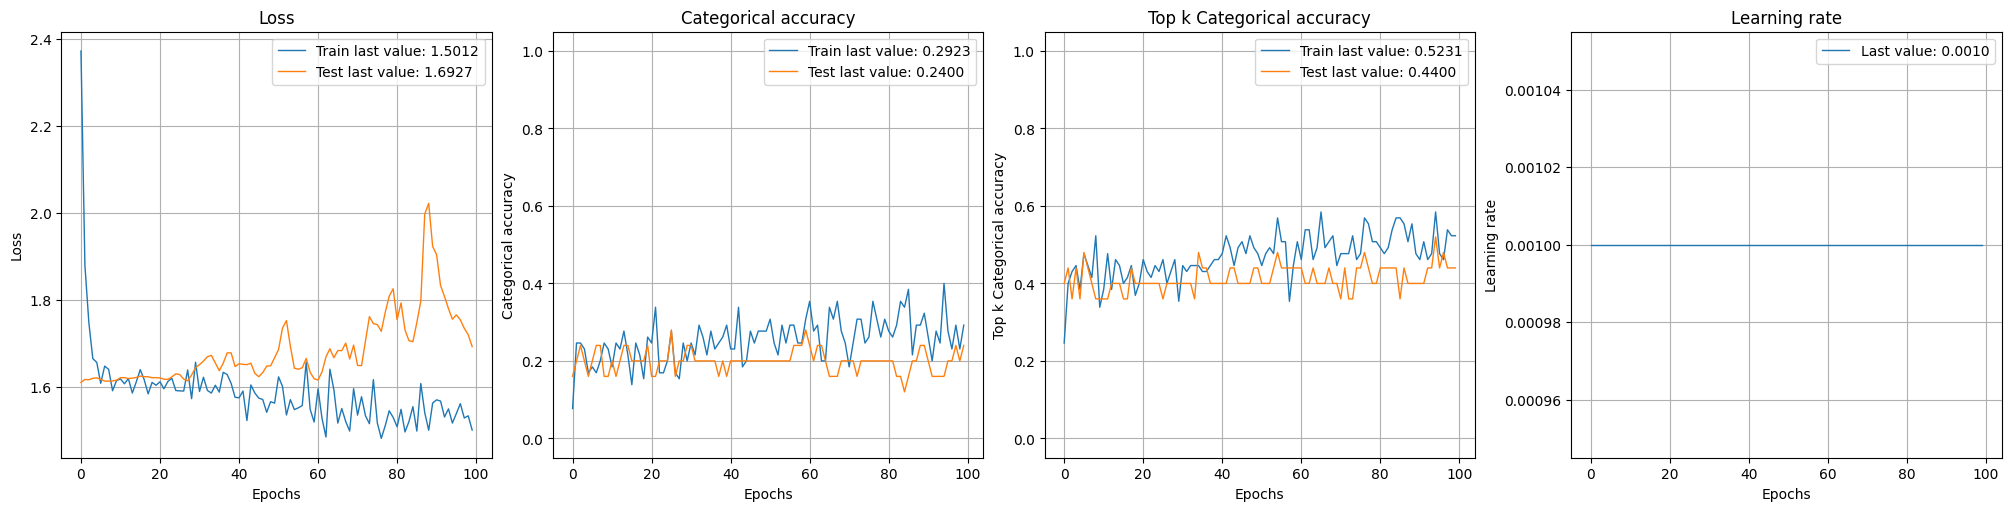

In [ ]:
plot_history(history, path="history_cnn.png")

### VGG19

In [ ]:
inputs = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
backbone = keras.applications.VGG19(
    include_top=False,
    weights='imagenet',
    input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
    pooling=None,
    #include_preprocessing=False,
)
backbone.trainable = False
x = backbone(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

model_cls = Model(inputs, outputs, name='facial_exp_cls') # 41 - 50 6 classes B2 32, 0.001, 128
model_cls.summary()

Model: "facial_exp_cls"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d_4  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_43 (Dropout)        (None, 512)               0         
                                                                 
 batch_normalization_9 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dense_6 (Dense)             (None, 5)              

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss = keras.losses.CategoricalCrossentropy(from_logits=False)
metrics = [keras.metrics.CategoricalAccuracy(), keras.metrics.TopKCategoricalAccuracy(k=2)]
model_cls.compile(optimizer=optimizer,
             loss=loss,
             metrics=metrics)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.8,
                              patience=3, min_lr=5e-5)
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    start_from_epoch=10,
    restore_best_weights=True,
)

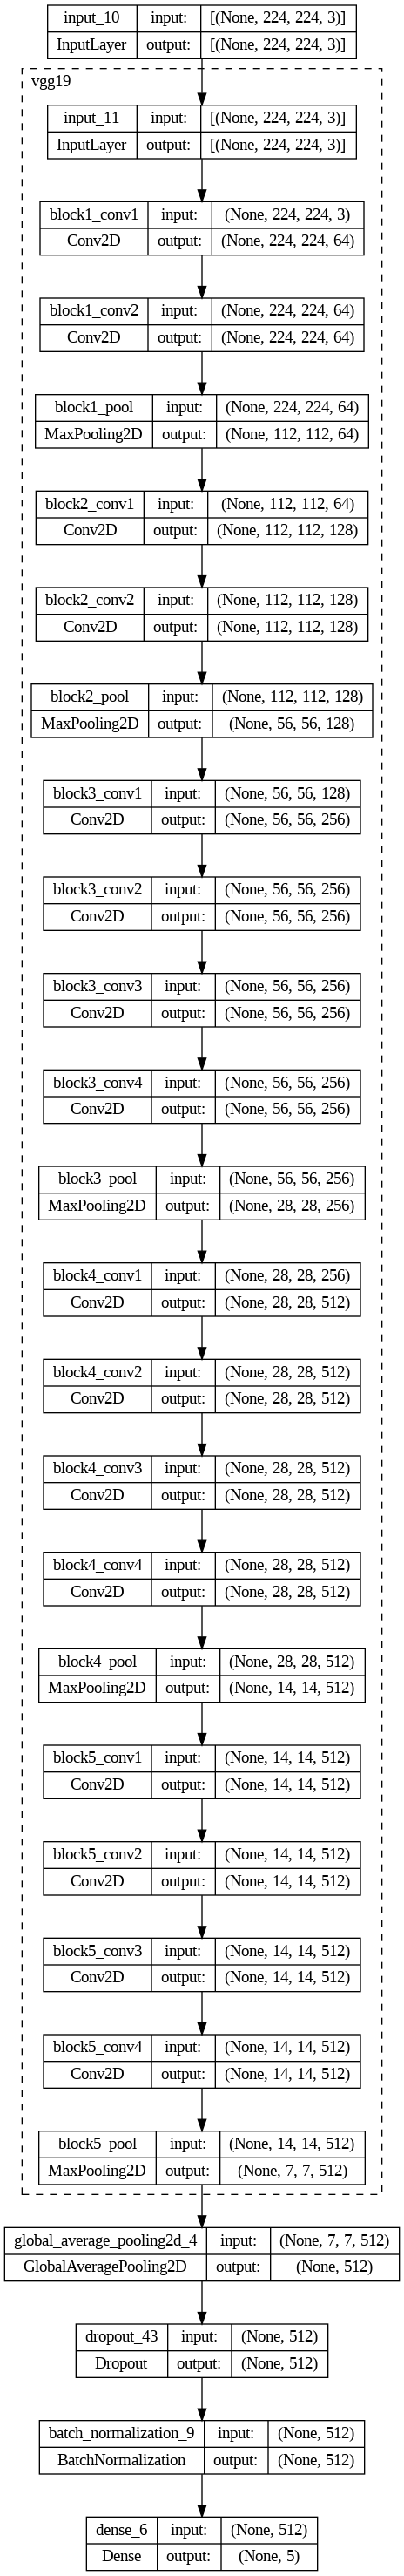

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_cls, to_file='model.png', show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96)

In [ ]:
history = model_cls.fit(dataset_train_m, epochs=100,
          validation_data=dataset_val_m, verbose=1, callbacks=[reduce_lr, early_stop])

Epoch 1/100
5/5 [==============================] - 19s 1s/step - loss: 2.2544 - categorical_accuracy: 0.1077 - top_k_categorical_accuracy: 0.2923 - val_loss: 1.7156 - val_categorical_accuracy: 0.2400 - val_top_k_categorical_accuracy: 0.4000 - lr: 0.0010
Epoch 2/100
5/5 [==============================] - 8s 960ms/step - loss: 1.7478 - categorical_accuracy: 0.2308 - top_k_categorical_accuracy: 0.5231 - val_loss: 1.6884 - val_categorical_accuracy: 0.2000 - val_top_k_categorical_accuracy: 0.4000 - lr: 0.0010
Epoch 3/100
5/5 [==============================] - 4s 429ms/step - loss: 1.9420 - categorical_accuracy: 0.1538 - top_k_categorical_accuracy: 0.4000 - val_loss: 1.6683 - val_categorical_accuracy: 0.2000 - val_top_k_categorical_accuracy: 0.4000 - lr: 0.0010
Epoch 4/100
5/5 [==============================] - 4s 436ms/step - loss: 1.9440 - categorical_accuracy: 0.2462 - top_k_categorical_accuracy: 0.4462 - val_loss: 1.6588 - val_categorical_accuracy: 0.2000 - val_top_k_categorical_accuracy

(<Figure size 2000x500 with 4 Axes>,
 array([<Axes: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <Axes: title={'center': 'Categorical accuracy'}, xlabel='Epochs', ylabel='Categorical accuracy'>,
        <Axes: title={'center': 'Top k Categorical accuracy'}, xlabel='Epochs', ylabel='Top k Categorical accuracy'>,
        <Axes: title={'center': 'Learning rate'}, xlabel='Epochs', ylabel='Learning rate'>],
       dtype=object))

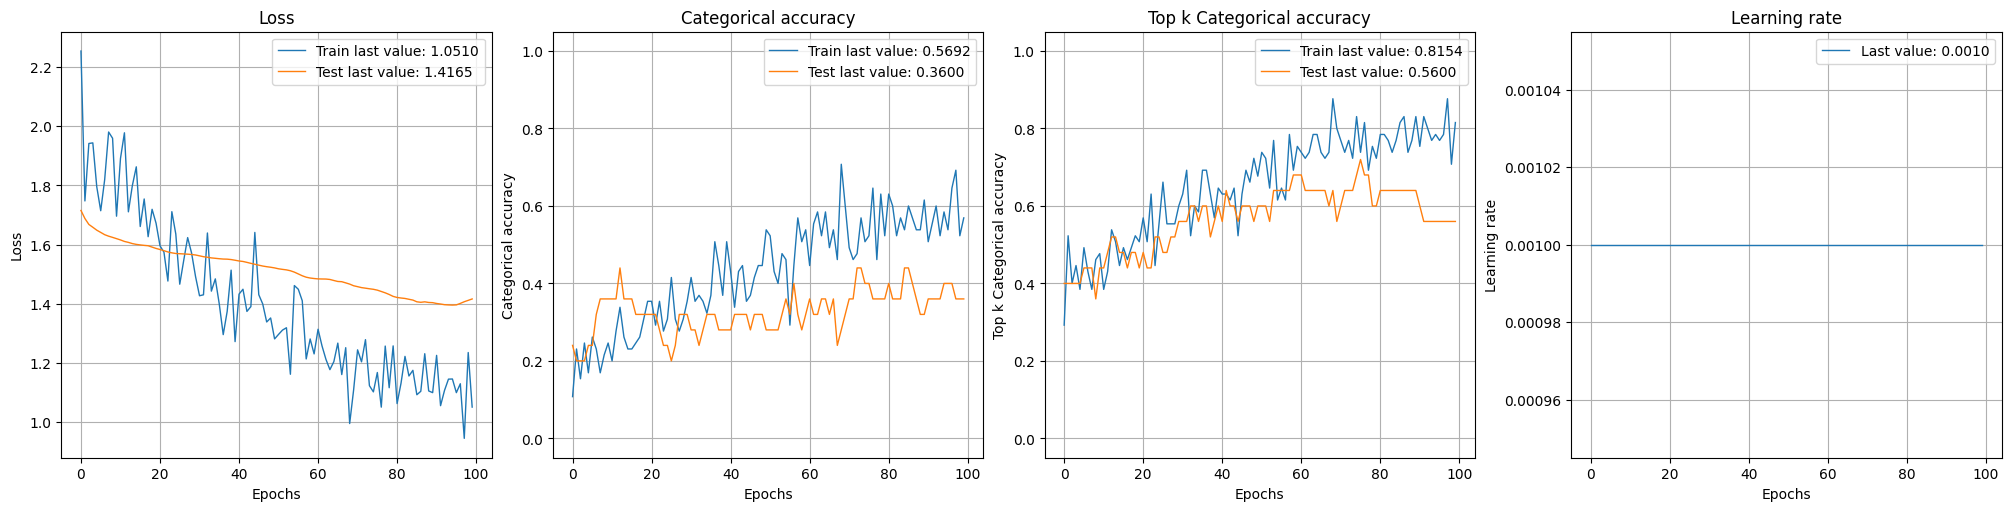

In [ ]:
plot_history(history, path="history_vgg.png")

# Xception

In [ ]:
inputs = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
backbone = keras.applications.Xception(
    include_top=False,
    weights='imagenet',
    input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
    pooling=None,
    #include_preprocessing=False,
)
backbone.trainable = False
x = backbone(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

model_cls_xp = Model(inputs, outputs, name='facial_exp_cls') # 41 - 50 6 classes B2 32, 0.001, 128
model_cls_xp.summary()

83683744/83683744 [==============================] - 1s 0us/step
Model: "facial_exp_cls"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 batch_normalization_5 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                     

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss = keras.losses.CategoricalCrossentropy(from_logits=False)
metrics = [keras.metrics.CategoricalAccuracy(), keras.metrics.TopKCategoricalAccuracy(k=2)]
model_cls_xp.compile(optimizer=optimizer,
             loss=loss,
             metrics=metrics)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.8,
                              patience=3, min_lr=5e-5)
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    start_from_epoch=10,
    restore_best_weights=True,
)

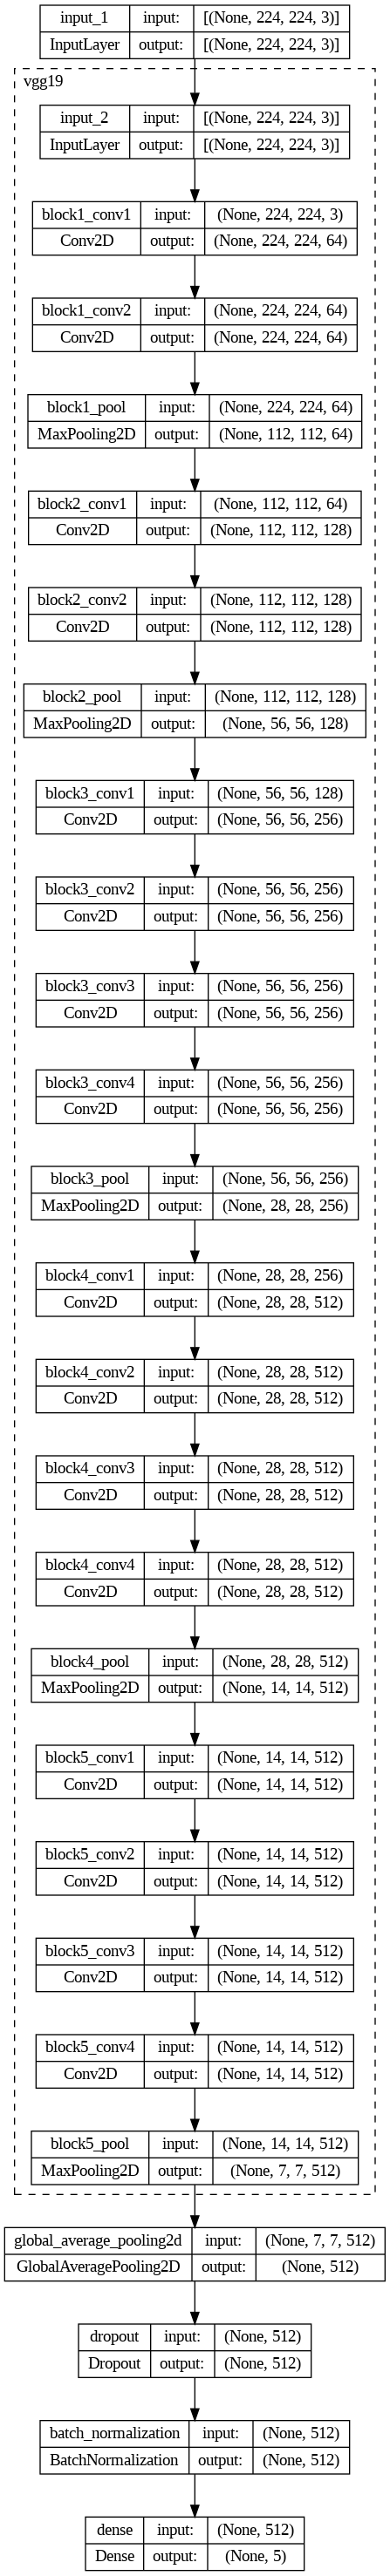

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_cls, to_file='model.png', show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96)

In [ ]:
history = model_cls_xp.fit(dataset_train_m, epochs=100,
          validation_data=dataset_val_m, verbose=1, callbacks=[reduce_lr, early_stop])

Epoch 1/100
5/5 [==============================] - 11s 891ms/step - loss: 2.1652 - categorical_accuracy: 0.1385 - top_k_categorical_accuracy: 0.4000 - val_loss: 1.6154 - val_categorical_accuracy: 0.2800 - val_top_k_categorical_accuracy: 0.4800 - lr: 0.0010
Epoch 2/100
5/5 [==============================] - 7s 481ms/step - loss: 2.0413 - categorical_accuracy: 0.1692 - top_k_categorical_accuracy: 0.4462 - val_loss: 1.6035 - val_categorical_accuracy: 0.2800 - val_top_k_categorical_accuracy: 0.4400 - lr: 0.0010
Epoch 3/100
5/5 [==============================] - 4s 424ms/step - loss: 1.9714 - categorical_accuracy: 0.3077 - top_k_categorical_accuracy: 0.4308 - val_loss: 1.5882 - val_categorical_accuracy: 0.2800 - val_top_k_categorical_accuracy: 0.4400 - lr: 0.0010
Epoch 4/100
5/5 [==============================] - 4s 421ms/step - loss: 1.7079 - categorical_accuracy: 0.3077 - top_k_categorical_accuracy: 0.5077 - val_loss: 1.5710 - val_categorical_accuracy: 0.3200 - val_top_k_categorical_accur

(<Figure size 2000x500 with 4 Axes>,
 array([<Axes: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <Axes: title={'center': 'Categorical accuracy'}, xlabel='Epochs', ylabel='Categorical accuracy'>,
        <Axes: title={'center': 'Top k Categorical accuracy'}, xlabel='Epochs', ylabel='Top k Categorical accuracy'>,
        <Axes: title={'center': 'Learning rate'}, xlabel='Epochs', ylabel='Learning rate'>],
       dtype=object))

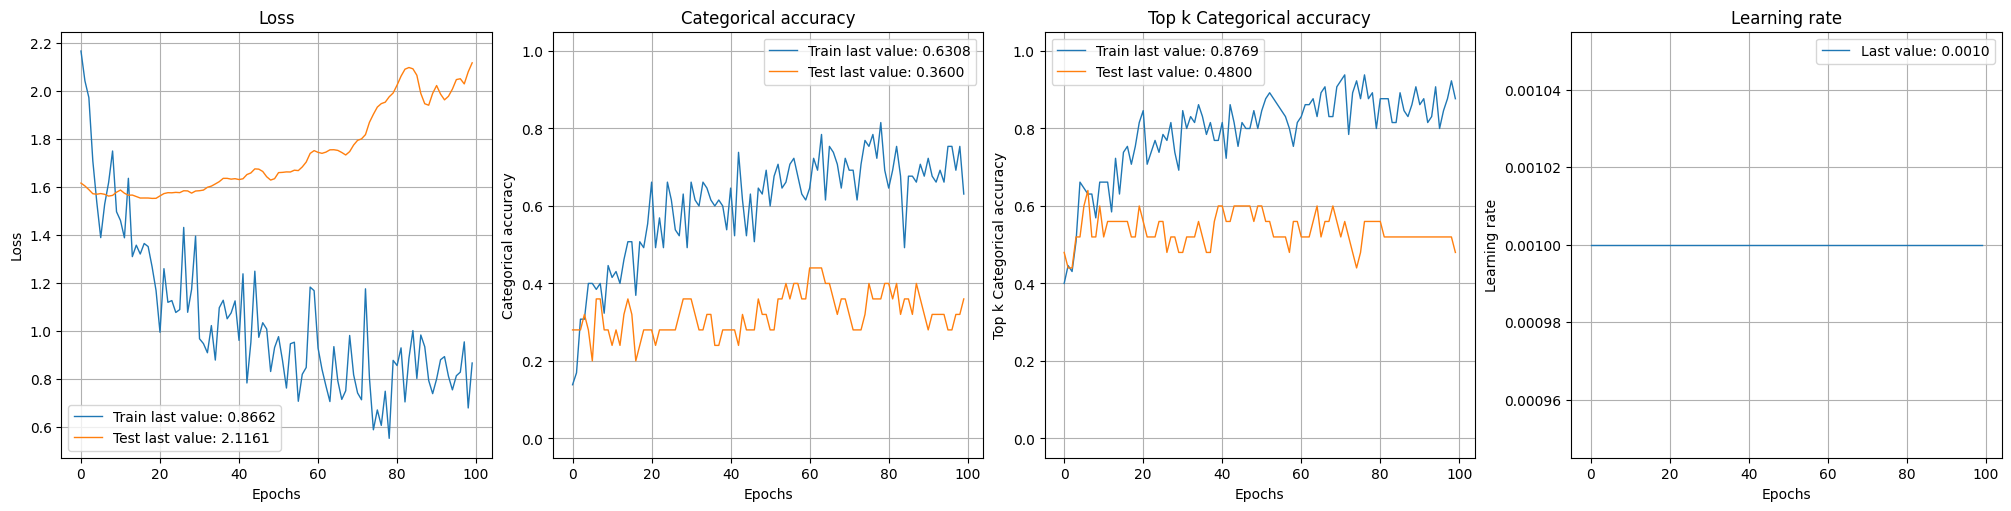

In [ ]:
plot_history(history, path="history_xp.png")

# ResNet50

In [ ]:
inputs = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
backbone = keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
    pooling=None,
    #include_preprocessing=False,
)
backbone.trainable = False
x = backbone(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

model_cls_res = Model(inputs, outputs, name='facial_exp_cls') # 41 - 50 6 classes B2 32, 0.001, 128
model_cls_res.summary()

optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss = keras.losses.CategoricalCrossentropy(from_logits=False)
metrics = [keras.metrics.CategoricalAccuracy(), keras.metrics.TopKCategoricalAccuracy(k=2)]
model_cls_res.compile(optimizer=optimizer,
             loss=loss,
             metrics=metrics)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.8,
                              patience=3, min_lr=5e-5)
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    start_from_epoch=10,
    restore_best_weights=True,
)

94765736/94765736 [==============================] - 0s 0us/step
Model: "facial_exp_cls"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 batch_normalization_6 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                     

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_cls_res, to_file='model.png', show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
history = model_cls_res.fit(dataset_train_m, epochs=100,
          validation_data=dataset_val_m, verbose=1, callbacks=[reduce_lr, early_stop])

Epoch 1/100
5/5 [==============================] - 12s 1s/step - loss: 1.7983 - categorical_accuracy: 0.1846 - top_k_categorical_accuracy: 0.3538 - val_loss: 1.8559 - val_categorical_accuracy: 0.2000 - val_top_k_categorical_accuracy: 0.4000 - lr: 0.0010
Epoch 2/100
5/5 [==============================] - 4s 407ms/step - loss: 1.7572 - categorical_accuracy: 0.2308 - top_k_categorical_accuracy: 0.4000 - val_loss: 1.7790 - val_categorical_accuracy: 0.1600 - val_top_k_categorical_accuracy: 0.4000 - lr: 0.0010
Epoch 3/100
5/5 [==============================] - 4s 406ms/step - loss: 1.6913 - categorical_accuracy: 0.2154 - top_k_categorical_accuracy: 0.4154 - val_loss: 1.7261 - val_categorical_accuracy: 0.1600 - val_top_k_categorical_accuracy: 0.4000 - lr: 0.0010
Epoch 4/100
5/5 [==============================] - 11s 1s/step - loss: 1.6703 - categorical_accuracy: 0.2308 - top_k_categorical_accuracy: 0.4462 - val_loss: 1.6907 - val_categorical_accuracy: 0.2000 - val_top_k_categorical_accuracy: 

(<Figure size 2000x500 with 4 Axes>,
 array([<Axes: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <Axes: title={'center': 'Categorical accuracy'}, xlabel='Epochs', ylabel='Categorical accuracy'>,
        <Axes: title={'center': 'Top k Categorical accuracy'}, xlabel='Epochs', ylabel='Top k Categorical accuracy'>,
        <Axes: title={'center': 'Learning rate'}, xlabel='Epochs', ylabel='Learning rate'>],
       dtype=object))

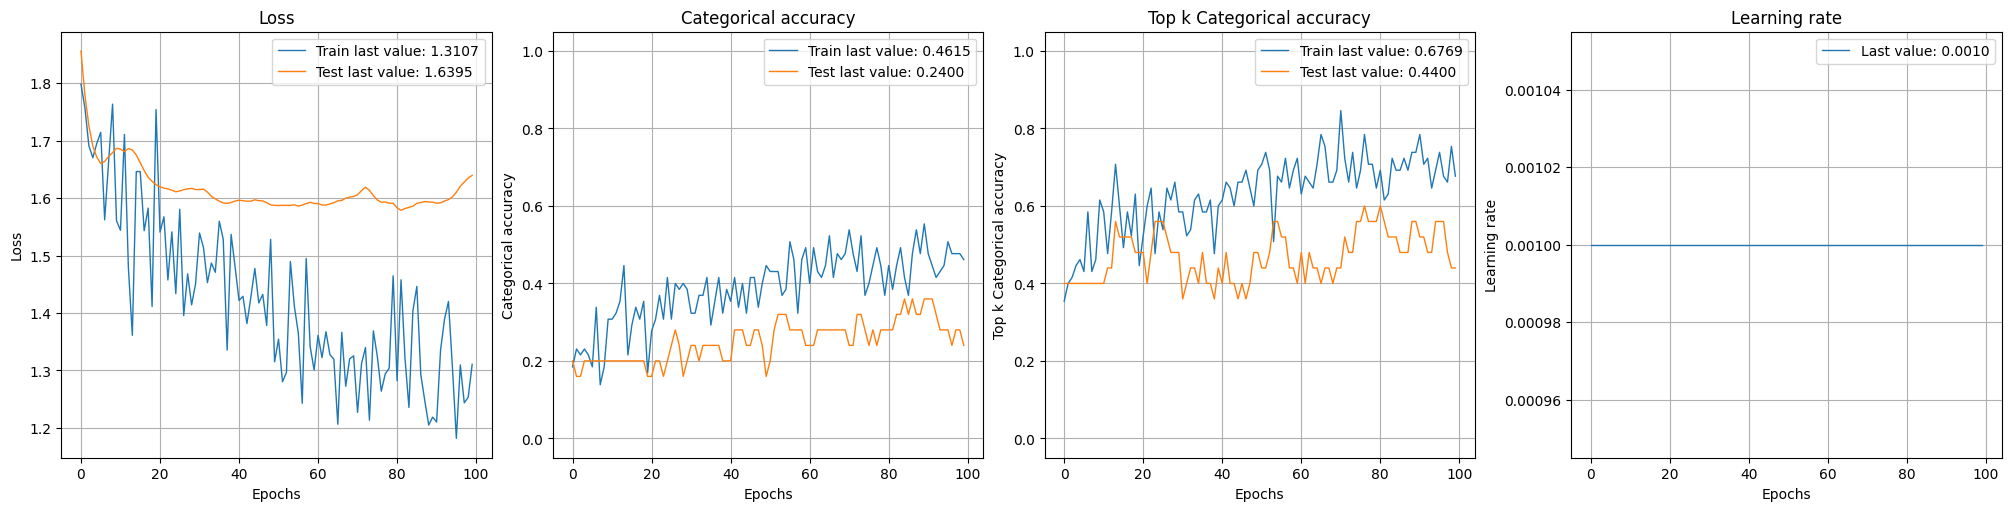

In [ ]:
plot_history(history, path="history_res.png")

# MobileNet

In [ ]:
inputs = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
backbone = keras.applications.MobileNetV3Small(
    include_top=False,
    weights='imagenet',
    input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
    pooling=None,
    #include_preprocessing=False,
)
backbone.trainable = False
x = backbone(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

model_cls_mob = Model(inputs, outputs, name='facial_exp_cls') # 41 - 50 6 classes B2 32, 0.001, 128
model_cls_mob.summary()

optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss = keras.losses.CategoricalCrossentropy(from_logits=False)
metrics = [keras.metrics.CategoricalAccuracy(), keras.metrics.TopKCategoricalAccuracy(k=2)]
model_cls_mob.compile(optimizer=optimizer,
             loss=loss,
             metrics=metrics)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.8,
                              patience=3, min_lr=5e-5)

early_stop = keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    start_from_epoch=10,
    restore_best_weights=True,
)

4334752/4334752 [==============================] - 0s 0us/step
Model: "facial_exp_cls"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3small (Function  (None, 7, 7, 576)         939120    
 al)                                                             
                                                                 
 global_average_pooling2d_3  (None, 576)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_3 (Dropout)         (None, 576)               0         
                                                                 
 batch_normalization_7 (Bat  (None, 576)               2304      
 chNormalization)                                      

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_cls_mob, to_file='model.png', show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
history_mob = model_cls_mob.fit(dataset_train_m, epochs=100,
          validation_data=dataset_val_m, verbose=1, callbacks=[reduce_lr, early_stop])

Epoch 1/100
5/5 [==============================] - 12s 985ms/step - loss: 2.1302 - categorical_accuracy: 0.1538 - top_k_categorical_accuracy: 0.2923 - val_loss: 1.7020 - val_categorical_accuracy: 0.2000 - val_top_k_categorical_accuracy: 0.4400 - lr: 0.0010
Epoch 2/100
5/5 [==============================] - 5s 610ms/step - loss: 1.8804 - categorical_accuracy: 0.2308 - top_k_categorical_accuracy: 0.4000 - val_loss: 1.7034 - val_categorical_accuracy: 0.2000 - val_top_k_categorical_accuracy: 0.4400 - lr: 0.0010
Epoch 3/100
5/5 [==============================] - 4s 349ms/step - loss: 1.9843 - categorical_accuracy: 0.1846 - top_k_categorical_accuracy: 0.3692 - val_loss: 1.6969 - val_categorical_accuracy: 0.2000 - val_top_k_categorical_accuracy: 0.4800 - lr: 0.0010
Epoch 4/100
5/5 [==============================] - 5s 665ms/step - loss: 2.0779 - categorical_accuracy: 0.1692 - top_k_categorical_accuracy: 0.3385 - val_loss: 1.6854 - val_categorical_accuracy: 0.2000 - val_top_k_categorical_accur

(<Figure size 2000x500 with 4 Axes>,
 array([<Axes: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <Axes: title={'center': 'Categorical accuracy'}, xlabel='Epochs', ylabel='Categorical accuracy'>,
        <Axes: title={'center': 'Top k Categorical accuracy'}, xlabel='Epochs', ylabel='Top k Categorical accuracy'>,
        <Axes: title={'center': 'Learning rate'}, xlabel='Epochs', ylabel='Learning rate'>],
       dtype=object))

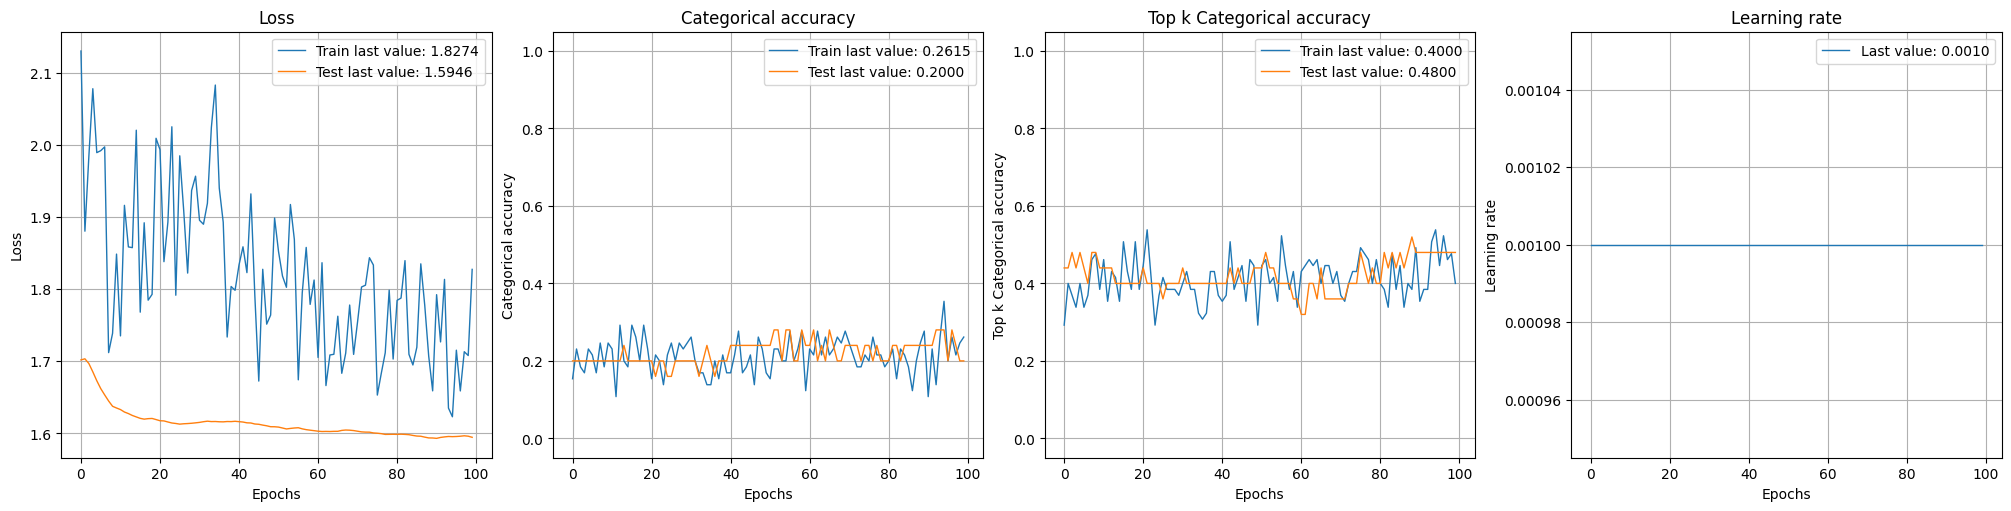

In [ ]:
plot_history(history_mob, path="history_mob.png")

### ViT

In [ ]:
buffer_size = len(data)
dataset_train_t = dataset_train.map(partial(image_preprocessing, scale=False), num_parallel_calls=AUTOTUNE
                                  ).shuffle(buffer_size = buffer_size,
                                      reshuffle_each_iteration = True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
dataset_val_t = dataset_val.shuffle(buffer_size = buffer_size,
                                      reshuffle_each_iteration = True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
model_name = 'google/vit-base-patch16-224-in21k'
base_model = TFViTModel.from_pretrained(model_name)
inputs = Input(shape=(224, 224, 3))
x = Permute((3, 1, 2))(inputs)
base_model.trainable = False
x = base_model.vit(x)[0]
x = keras.layers.GlobalAveragePooling1D()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu', kernel_regularizer=keras.regularizers.L2(0.01))(x) # batchnorm
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)
hf_model = Model(inputs=inputs, outputs=outputs, name='ViT_cls')

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/346M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFViTModel.

All the layers of TFViTModel were initialized from the model checkpoint at google/vit-base-patch16-224-in21k.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


In [ ]:
hf_model.summary()

Model: "ViT_cls"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 permute (Permute)           (None, 3, 224, 224)       0         
                                                                 
 vit (TFViTMainLayer)        TFBaseModelOutputWithPo   86389248  
                             oling(last_hidden_state             
                             =(None, 197, 768),                  
                              pooler_output=(None, 7             
                             68),                                
                              hidden_states=None, at             
                             tentions=None)                      
                                                                 
 global_average_pooling1d (  (None, 768)               0   

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss = keras.losses.CategoricalCrossentropy(from_logits=False)
metrics = [keras.metrics.CategoricalAccuracy(), keras.metrics.TopKCategoricalAccuracy(k=2)]
hf_model.compile(optimizer=optimizer,
             loss=loss,
             metrics=metrics)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.8,
                              patience=3, min_lr=5e-5)
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    start_from_epoch=10,
)

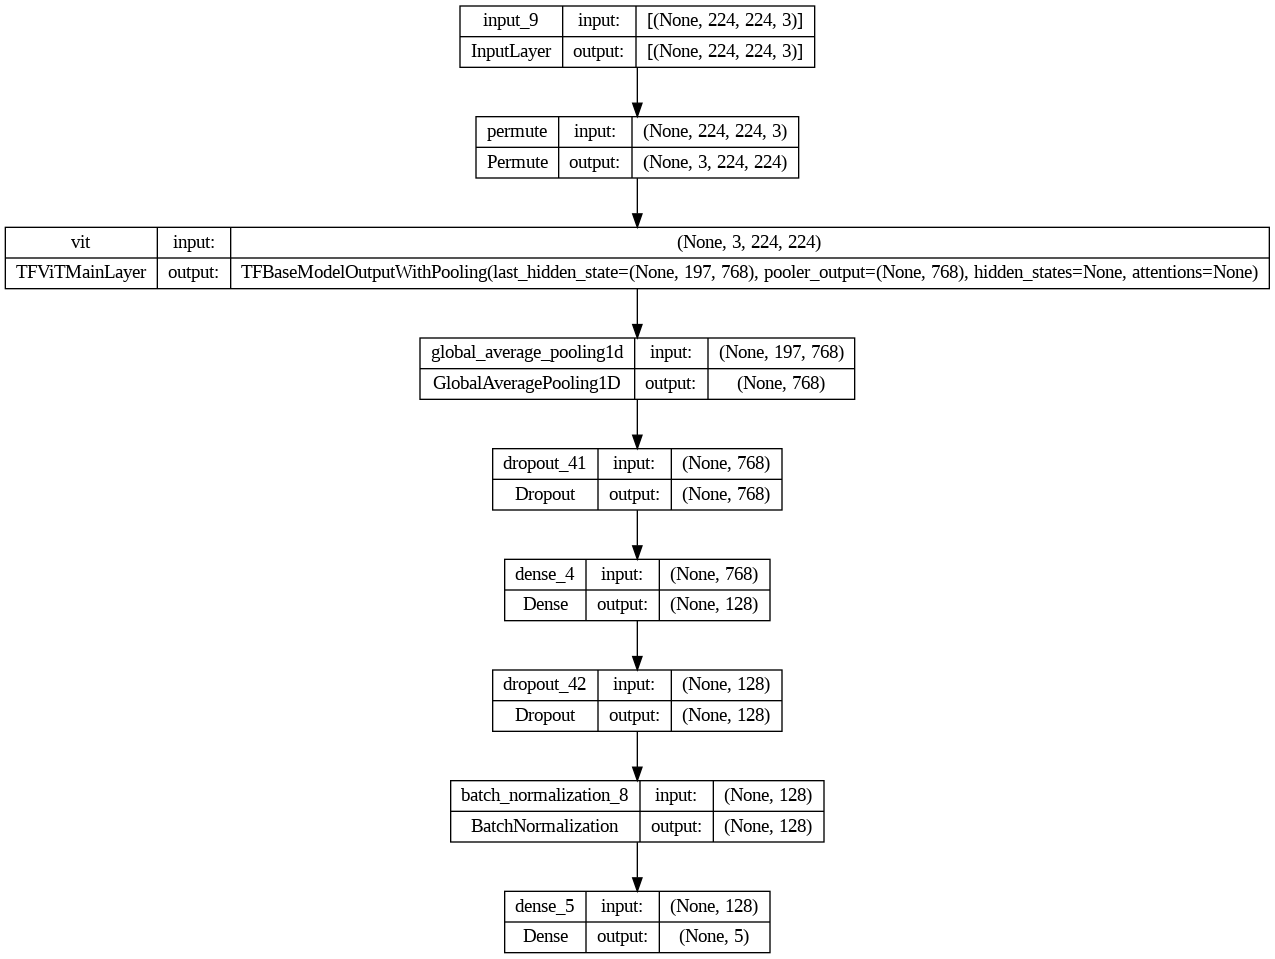

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(hf_model, to_file='model.png', show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96)

In [ ]:
history = hf_model.fit(dataset_train_t, epochs=100,
          validation_data=dataset_val_t, verbose=1, callbacks=[reduce_lr, early_stop])

Epoch 1/100
5/5 [==============================] - 21s 1s/step - loss: 4.3987 - categorical_accuracy: 0.1692 - top_k_categorical_accuracy: 0.3538 - val_loss: 3.7443 - val_categorical_accuracy: 0.2400 - val_top_k_categorical_accuracy: 0.4800 - lr: 0.0010
Epoch 2/100
5/5 [==============================] - 6s 607ms/step - loss: 4.0826 - categorical_accuracy: 0.2308 - top_k_categorical_accuracy: 0.5846 - val_loss: 3.7074 - val_categorical_accuracy: 0.2800 - val_top_k_categorical_accuracy: 0.5200 - lr: 0.0010
Epoch 3/100
5/5 [==============================] - 5s 619ms/step - loss: 3.9831 - categorical_accuracy: 0.2462 - top_k_categorical_accuracy: 0.4923 - val_loss: 3.6753 - val_categorical_accuracy: 0.2400 - val_top_k_categorical_accuracy: 0.5600 - lr: 0.0010
Epoch 4/100
5/5 [==============================] - 7s 808ms/step - loss: 3.7318 - categorical_accuracy: 0.3846 - top_k_categorical_accuracy: 0.5538 - val_loss: 3.6452 - val_categorical_accuracy: 0.3200 - val_top_k_categorical_accuracy

(<Figure size 2000x500 with 4 Axes>,
 array([<Axes: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <Axes: title={'center': 'Categorical accuracy'}, xlabel='Epochs', ylabel='Categorical accuracy'>,
        <Axes: title={'center': 'Top k Categorical accuracy'}, xlabel='Epochs', ylabel='Top k Categorical accuracy'>,
        <Axes: title={'center': 'Learning rate'}, xlabel='Epochs', ylabel='Learning rate'>],
       dtype=object))

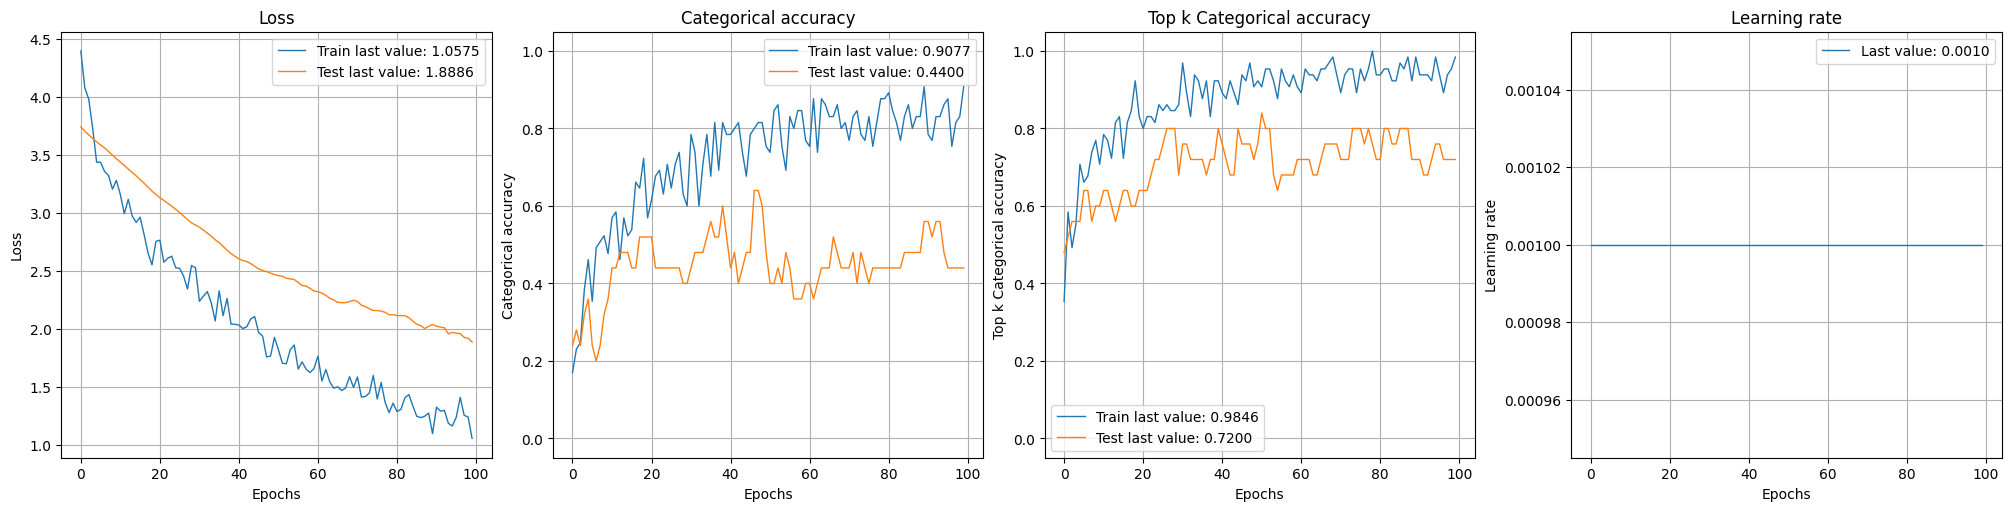

In [ ]:
plot_history(history, path="history_ViT.png")

## 3. ViT model evaluation

In [ ]:
input_prepoccess_f = lambda image, label: (2. * image - 1., label)
dataset_t_ = tf.keras.utils.image_dataset_from_directory(
    directory=path_val,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASSES,
    color_mode='rgb',
    batch_size=None,
    image_size=IMAGE_SIZE,
    shuffle=False,
    validation_split=None,
).map(image_scale, num_parallel_calls=AUTOTUNE)
dataset_t_t = dataset_t_.batch(1)

Found 25 files belonging to 5 classes.


In [ ]:
pred = hf_model.predict(dataset_t_t)

25/25 [==============================] - 5s 74ms/step


In [ ]:
def view_image_pred(ds, pred, num_plt=4):
    bs = pred.shape[0]
    fig = plt.figure(figsize=(10, 15))
    for i, (image, label) in enumerate(ds.as_numpy_iterator()):
        ax = fig.add_subplot(num_plt, bs // num_plt, i + 1, xticks=[], yticks=[])
        ax.imshow((image[0] + 1.) * 0.5)
        ax.set_title(f"t={CLASSES[np.argmax(label)]}, p={np.array(CLASSES)[np.argsort(pred[i])[-2:][::-1]]}", fontsize=7)

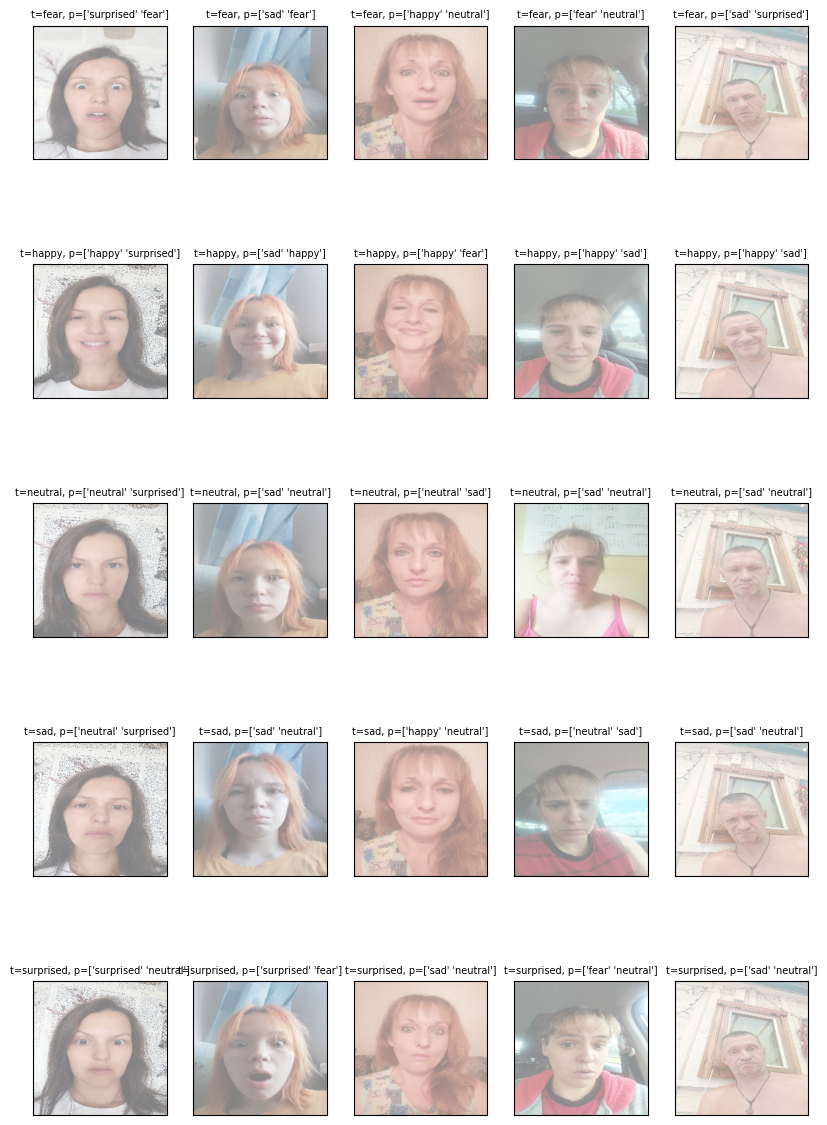

In [ ]:
view_image_pred(dataset_t_t, pred, num_plt=5) # true (t) label and predicted (p) with two highest probability

In [ ]:
y_true = np.stack([label[0] for _, label in dataset_t_t.as_numpy_iterator()])
y_true = np.argmax(y_true, axis=-1)
y_pred = np.argmax(pred, axis=-1)
print(classification_report(y_true, y_pred, target_names=CLASSES, digits=2))

              precision    recall  f1-score   support

        fear       0.50      0.20      0.29         5
       happy       0.67      0.80      0.73         5
     neutral       0.50      0.40      0.44         5
         sad       0.20      0.40      0.27         5
   surprised       0.67      0.40      0.50         5

    accuracy                           0.44        25
   macro avg       0.51      0.44      0.44        25
weighted avg       0.51      0.44      0.44        25



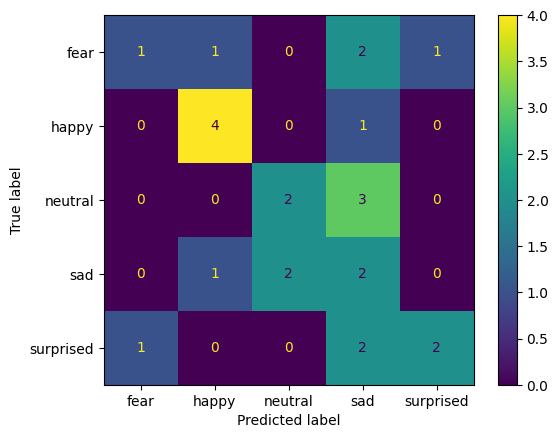

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels=CLASSES)
disp.plot()
plt.show()